In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [14]:
folder_path = "/content/drive/My Drive/Kaggle/"

train_data = pd.read_csv(folder_path + "train.csv")

In [15]:
features = ["Brand", "Material", "Size", "Compartments", "Laptop Compartment",
            "Waterproof", "Style", "Color", "Weight Capacity (kg)"]
target = "Price"

In [16]:
missing_cols = [col for col in features + [target] if col not in train_data.columns]
if missing_cols:
    raise KeyError(f"Missing columns in dataset: {missing_cols}")

In [17]:
X = train_data[features]
y = train_data[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [19]:
def create_preprocessor(categorical_cols, numerical_cols):
    numerical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ]
    )
    return preprocessor

preprocessor = create_preprocessor(categorical_cols, numerical_cols)

In [20]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

In [21]:
print(f"Number of features after encoding: {X_train_preprocessed.shape[1]}")

Number of features after encoding: 27


In [22]:
param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

In [23]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    verbose=2, n_jobs=-1
)
random_search.fit(X_train_preprocessed, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 15, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [24]:
best_rf = random_search.best_estimator_
print("\nBest Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}


In [25]:
train_predictions = best_rf.predict(X_train_preprocessed)
mae_train = mean_absolute_error(y_train, train_predictions)
mse_train = mean_squared_error(y_train, train_predictions)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, train_predictions)

print("\nTraining Performance:")
print(f"MAE: {mae_train:.2f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, R²: {r2_train:.2f}")


Training Performance:
MAE: 33.49, MSE: 1496.68, RMSE: 38.69, R²: 0.02


In [26]:
val_predictions = best_rf.predict(X_val_preprocessed)
mae_val = mean_absolute_error(y_val, val_predictions)
mse_val = mean_squared_error(y_val, val_predictions)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, val_predictions)

print("\nValidation Performance:")
print(f"MAE: {mae_val:.2f}, MSE: {mse_val:.2f}, RMSE: {rmse_val:.2f}, R²: {r2_val:.2f}")


Validation Performance:
MAE: 33.65, MSE: 1515.21, RMSE: 38.93, R²: 0.00


In [27]:
cv_scores = cross_val_score(best_rf, X_train_preprocessed, y_train, cv=5, scoring="r2")
print("\nCross-Validation R² Scores:", cv_scores)
print(f"Mean R² Score: {cv_scores.mean():.2f}")


Cross-Validation R² Scores: [0.00101976 0.0003188  0.00044246 0.00066715 0.00070602]
Mean R² Score: 0.00


In [28]:
model_path = folder_path + "backpack_price_model.pkl"
joblib.dump(best_rf, model_path)
print(f"Model saved at: {model_path}")

Model saved at: /content/drive/My Drive/Kaggle/backpack_price_model.pkl


In [29]:
preprocessor_path = folder_path + "preprocessor.pkl"
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved at: {preprocessor_path}")

Preprocessor saved at: /content/drive/My Drive/Kaggle/preprocessor.pkl


In [30]:
validation_output = X_val.copy()
validation_output["Actual_Price"] = y_val
validation_output["Predicted_Price"] = val_predictions

csv_output_path = folder_path + "validation_predictions.csv"
validation_output.to_csv(csv_output_path, index=False)
print(f"Validation predictions saved at: {csv_output_path}")

Validation predictions saved at: /content/drive/My Drive/Kaggle/validation_predictions.csv


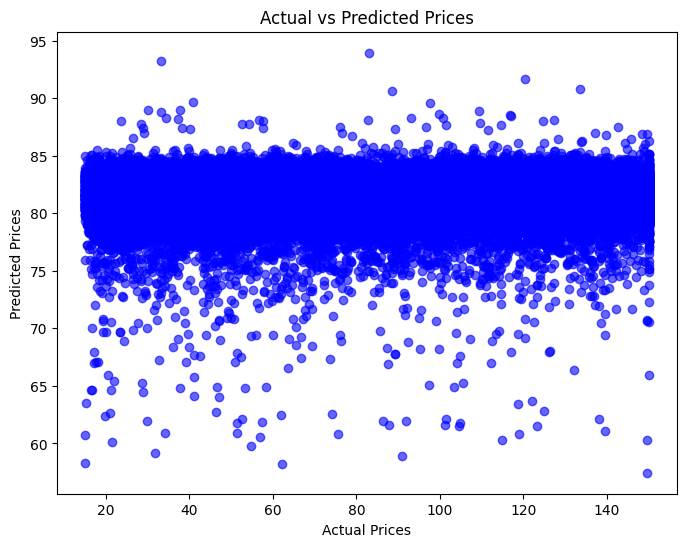

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, val_predictions, alpha=0.6, color='blue')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

In [ ]:
best_rf = joblib.load(folder_path + "backpack_price_model.pkl")
preprocessor = joblib.load(folder_path + "preprocessor.pkl")

new_data = pd.DataFrame([{
    "Brand": "Nike",
    "Material": "Polyester",
    "Size": "Medium",
    "Compartments": 3,
    "Laptop Compartment": "Yes",
    "Waterproof": "No",
    "Style": "Casual",
    "Color": "Black",
    "Weight Capacity (kg)": 10
}])

new_data_preprocessed = preprocessor.transform(new_data)

predicted_price = best_rf.predict(new_data_preprocessed)[0]
print(f"Predicted Price: {predicted_price}")


Predicted Price: 84.84672487371408
